# Heuristic Optimization

In [45]:
%load_ext autoreload
%autoreload 2
import soiling_model.cleaning_optimization as co
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import (rcParams,dates,colors)
rcParams['figure.figsize'] = (15, 7)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
d = "woomera_demo/" 
params = d+"parameters.xlsx"
weather = d+'woomera_data.xlsx'
SF = d+'SF_woomera_SolarPILOT.csv'            # solar field of 48 sectors located in Woomera
climate_file = d+'woomera_location_modified.epw'
n_az = 16        # number of azimuth partitions for the field sectors
n_rad = 15       # number of radial partitions for the field sectors
n_sol_az = 10   # number of solar azimuth angles for the efficiency lookup table
n_sol_el = 10  # number of solar elevation angles for the efficiency lookup table
second_surface = True # second_surface = False uses a first-surface model for the reflectance loss
n_sectors_cleaned_per_truck = 1 # number of sectors cleaned in a day by one truck
model_type = 'semi-physical'

Build soiling model, import inputs, and sectorize the field

In [47]:
sec = (n_rad,n_az)
opt = co.optimization_problem(  params,
                                SF,
                                weather,climate_file,sec,
                                dust_type="PM10",
                                second_surface=second_surface,
                                n_az=n_sol_az,
                                n_el=n_sol_el,
                                verbose=True,
                                model_type=model_type,
                                ext_options={'grid_size_x':250})

Importing site data (weather,time). Using dust_type = PM10, test_length = 364 days
Importing airtemp data as air_temp...
Importing windspeed data as wind_speed...
Importing dni data as dni...
No rain_intensity data to import.
Importing rh data as relative_humidity...
No wind_direction data to import.
No PM_tot data to import.
No TSP data to import.
Importing PM10 data...
No PM2p5 data to import.
No PM1 data to import.
No PM4 data to import.
Length of simulation for file woomera_demo/woomera_data.xlsx: 364 days
Importing dust properties for each experiment
Added PM10 attribute to dust class to all experiment dust classes
Loading source (normalized) intensity from woomera_demo/woomera_data.xlsx

Loading data from woomera_demo/parameters.xlsx ... 

Importing constants
Importing full solar field and sectorizing with 16 angular and 15 radial sectors
Calculating sun apparent movement and angles for 1 simulations


c:\Users\Cody Anderson\miniconda3\envs\heliosoil_env\Lib\site-packages\pysolar\numeric.py:62: UserWarning: no explicit representation of timezones available for np.datetime64
  dd = numpy.array(d, dtype='datetime64[D]')
c:\Users\Cody Anderson\miniconda3\envs\heliosoil_env\Lib\site-packages\pysolar\numeric.py:63: UserWarning: no explicit representation of timezones available for np.datetime64
  dy = numpy.array(d, dtype='datetime64[Y]')
c:\Users\Cody Anderson\miniconda3\envs\heliosoil_env\Lib\site-packages\pysolar\radiation.py:50: RuntimeWarning: overflow encountered in exp
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime
c:\Users\Cody Anderson\miniconda3\envs\heliosoil_env\Lib\site-packages\pysolar\radiation.py:50: RuntimeWarning: invalid value encountered in scalar multiply
  return flux * math.exp(-1 * optical_depth * air_mass_ratio) * is_daytime


Calculating heliostat movement and angles for 1 simulations
Second surface model
Acceptance angle range: (8.5, 37.6)
Loss Model is geometry. Setting extinction coefficients to unity for all heliostats in all files.
No value for hrz0 supplied. Using value in self.hrz0 = 5.8.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Calculating soil deposited in a timestep [m^2/m^2]
Getting efficiencies for az=0.000, el=10.000
Power absorbed by receiver at DNI=1000 W/m2: 4.28e+05 kW
Getting efficiencies for az=0.000, el=18.889
Power absorbed by receiver at DNI=1000 W/m2: 5.89e+05 kW
Getting efficiencies for az=0.000, el=27.778
Power absorbed by receiver at DNI=1000 W/m2: 6.56e+05 kW
Getting efficiencies for az=0.000, el=36.667
Power absorbed by receiver at DNI=1000 W/m2: 6.91e+05 kW
Getting efficiencies for az=0.000, el=45

Grid search number of trucks and annual cleans to optimize cleaning resources and frequencies.

In [48]:
helio_area = opt.field_model.helios.height*opt.field_model.helios.width
n_helios = opt.field_model.helios.full_field['x'].shape[0]
area_per_sector = n_helios/n_az/n_rad*helio_area
opt.truck = {   'operator_salary':80e3,
                'operators_per_truck_per_day':4,
                'purchase_cost':150e3,
                'maintenance_costs':15e3,
                'useful_life': 4,
                'fuel_cost': 0.005*area_per_sector,
                'water_cost': 0.005*area_per_sector
            }
opt.electricity_price = 50/1e6
opt.plant_other_maintenace = 0.0
opt.plant.receiver['thermal_max'] = 1e3 # MW
opt.plant.receiver['thermal_min'] = 105 # MW

Examine DNI statistics for a certain experiment

Text(0, 0.5, 'Frequency')

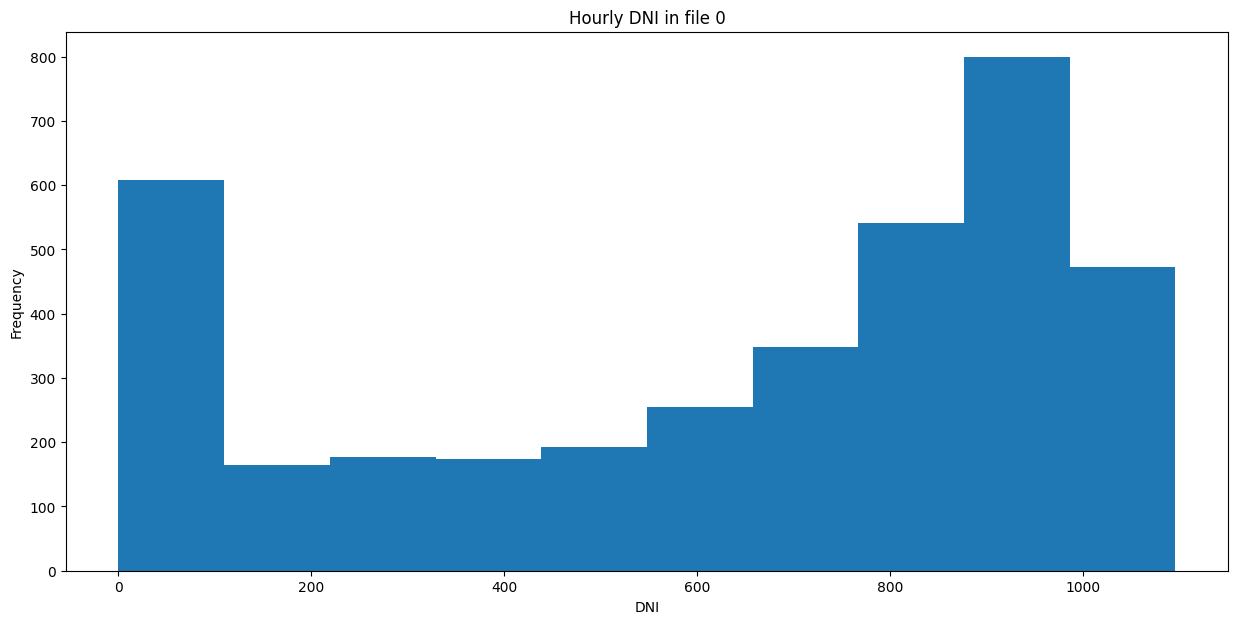

In [49]:
f = 0
DNI = opt.simulation_data.dni[f].copy()
se = opt.field_model.sun.elevation[f]
DNI[se<opt.field_model.sun.stow_angle] = np.nan
fig,ax = plt.subplots()
ax.hist(DNI)
ax.set_title(f"Hourly DNI in file {f}")
ax.set_xlabel("DNI")
ax.set_ylabel("Frequency")

Calculate bounds for field-averaged optical efficiency to provide full power under various DNI conditions

In [50]:
A_total = opt.field_model.helios.sector_area.sum()
# DNI_MW = 1e-6*np.nanpercentile(DNI,[50, 60, 70, 80, 90]) # MW/m^2
DNI_MW = 1e-6*np.array([200,300,500,700,900,1000])
u_limits = opt.plant.receiver['thermal_max']/DNI_MW/A_total
l_limits = opt.plant.receiver['thermal_min']/DNI_MW/A_total 
for ii,d in enumerate(DNI_MW):
    print(f"DNI: {d*1e6:.0f}, eta to hit max thermal of tower: {u_limits[ii]:.3f}")
    print(f"DNI: {d*1e6:.0f}, eta to hit min thermal of tower: {l_limits[ii]:.3f} \n")

DNI: 200, eta to hit max thermal of tower: 3.992
DNI: 200, eta to hit min thermal of tower: 0.419 

DNI: 300, eta to hit max thermal of tower: 2.661
DNI: 300, eta to hit min thermal of tower: 0.279 

DNI: 500, eta to hit max thermal of tower: 1.597
DNI: 500, eta to hit min thermal of tower: 0.168 

DNI: 700, eta to hit max thermal of tower: 1.141
DNI: 700, eta to hit min thermal of tower: 0.120 

DNI: 900, eta to hit max thermal of tower: 0.887
DNI: 900, eta to hit min thermal of tower: 0.093 

DNI: 1000, eta to hit max thermal of tower: 0.798
DNI: 1000, eta to hit min thermal of tower: 0.084 



Examine the soiling losses for each representative heliostat over the year

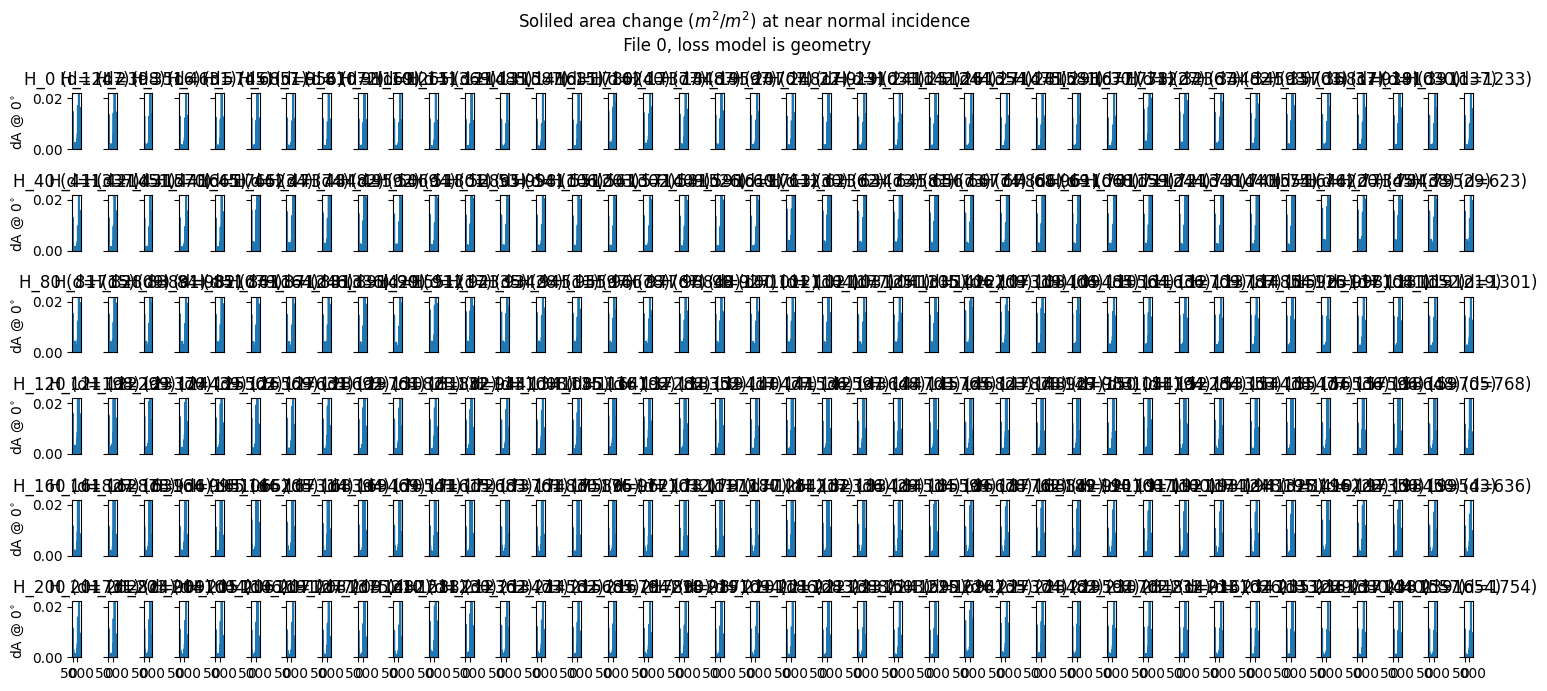

In [51]:
f,h = 0,10
nrows = 6
n_helios,n_hours = opt.field_model.helios.tilt[f].shape
ncols = int(n_helios/nrows)
fig,ax = plt.subplots(ncols=ncols,nrows=nrows,sharey=True)
hours = np.arange(0,n_hours)
helios = opt.field_model.helios
for r in range(nrows):
    for c in range(ncols):
        h = ncols*r+c
        ax[r,c].plot(hours,helios.delta_soiled_area[f][h,:])
        # ax[r,c].hist(helios.delta_soiled_area[f][h,:],100,density=True)
        ax[r,c].set_title(f'H_{h} (d={np.sqrt(helios.x[h]**2 + helios.y[h]**2):.0f})')
        ax[r,c].set_ylim((0,0.022))
        if r < nrows-1:
            ax[r,c].set_xticks(())
        if c==0:
            ax[r,c].set_ylabel(r"dA @ $0^{\circ}$ ")
fig.suptitle(f"Soliled area change "+ r"($m^2$/$m^2$)"+f" at near normal incidence \n File {f}, loss model is {opt.field_model.loss_model}")
plt.tight_layout()

Optimize via grid search on number of trucks and number of field cleans in a year

In [52]:
Nt = range(1,10)
Nc = range(1,51)
TCC = np.nan*np.ones((len(Nt),len(Nc)))
for ii in range(len(Nt)):
    n_trucks = Nt[ii]
    for jj in range(len(Nc)):
        n_cleans = Nc[jj]
        # print("Simulating {0:d} trucks with {1:d} cleans".format(n_trucks,n_cleans))
        results = co.periodic_schedule_tcc(opt,n_trucks,n_cleans,\
            n_sectors_per_truck=n_sectors_cleaned_per_truck,verbose=False)
        number_of_cleaning_finishes = results['cleaning_actions'][0].sum(axis=1)[-1]
        if  number_of_cleaning_finishes < n_cleans:
            print("Cleans maxed out")
            break
        else:
            TCC[ii,jj] = results['total_cleaning_costs']

C:\Users\Cody Anderson\AppData\Local\Temp\ipykernel_18928\2346548011.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  TCC[ii,jj] = results['total_cleaning_costs']


Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out


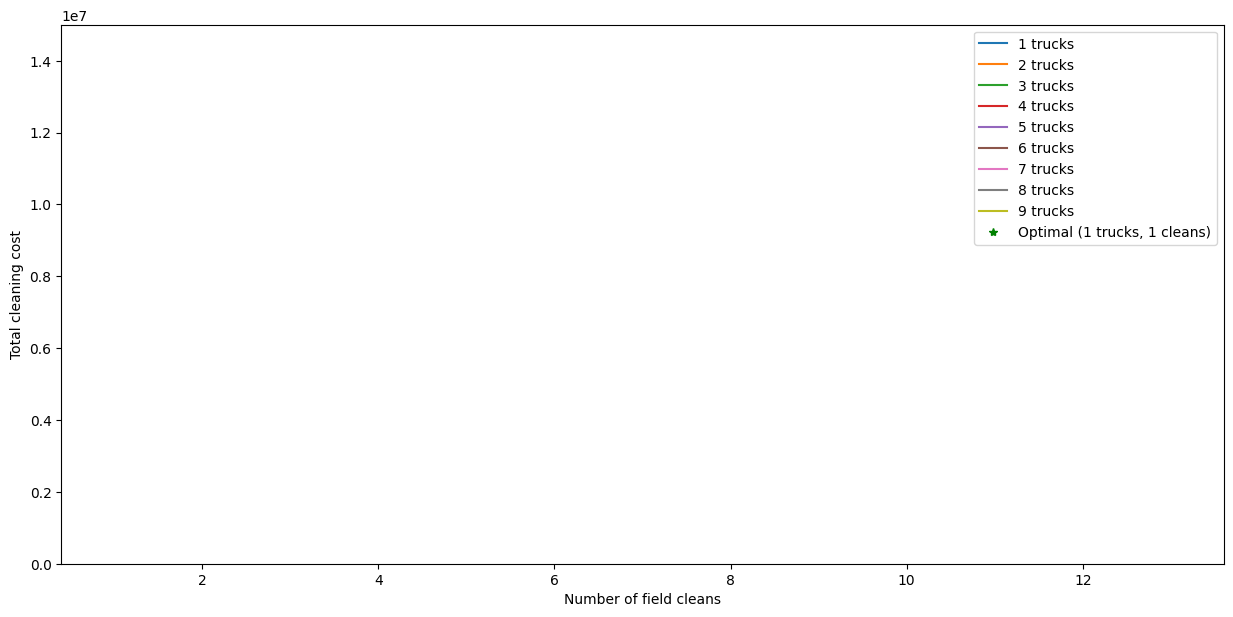

In [53]:
fig,ax = plt.subplots()
num_cleans = np.arange(start=Nc[0],stop=Nc[-1]+1)
for ii in Nt:
    ax.plot(num_cleans,TCC[ii-1,:],label=str(ii)+" trucks")

# optimal for each number of trucks
nc_opt = np.nanargmin(TCC,axis=1)
ax.plot(num_cleans[nc_opt],TCC[range(len(Nt)),nc_opt],linestyle="None",marker='*')

# overall optimal
nc_opt = np.nanargmin(TCC)
r,c = np.unravel_index(nc_opt,TCC.shape)
label_str = "Optimal ({0:d} trucks, {1:d} cleans)".format(r+1,c+1)
ax.plot(num_cleans[c],TCC[r,c],color='green',linestyle="None",marker='*',label=label_str)

ax.set_xlabel("Number of field cleans")
ax.set_ylabel("Total cleaning cost")
ax.set_ylim((0,15e6))
ax.legend()

Helper functions and strings for plotting

In [54]:
def add_limits(ax,ulim,llim,DMW):
    xl = ax.get_xlim()
    xloc = xl[0] + 0.0*(xl[1]-xl[0])
    for ii in range(len(ulim)):
        if ii == 0:
            ax.axhline(y=ulim[ii],color='gray',ls='--',label='Receiver capacity limit')
        else:
            ax.axhline(y=ulim[ii],color='gray',ls='--',label=None)

        if ulim[ii] < 1.0:
            ax.text(xloc,ulim[ii],f"DNI={DMW[ii]*1e6:.0f}",va='bottom')
        

        if ii == 0:
            ax.axhline(y=llim[ii],color='gray',ls=':',label='Receiver lower limit')
        else:
            ax.axhline(y=llim[ii],color='gray',ls=':',label=None)

        if l_limits[ii] > 0.2:
            ax.text(xloc,llim[ii],f"DNI={DMW[ii]*1e6:.0f}",va='bottom')

title_str = """     Results for {0:d} trucks, {1:d} field cleans
                    Number of cleans: {2:.1f}, average soiling factor: {3:.3f}
                    C_clean: {4:.2e}, C_deg: {5:.2e}
             """


(0.7, 1.0)

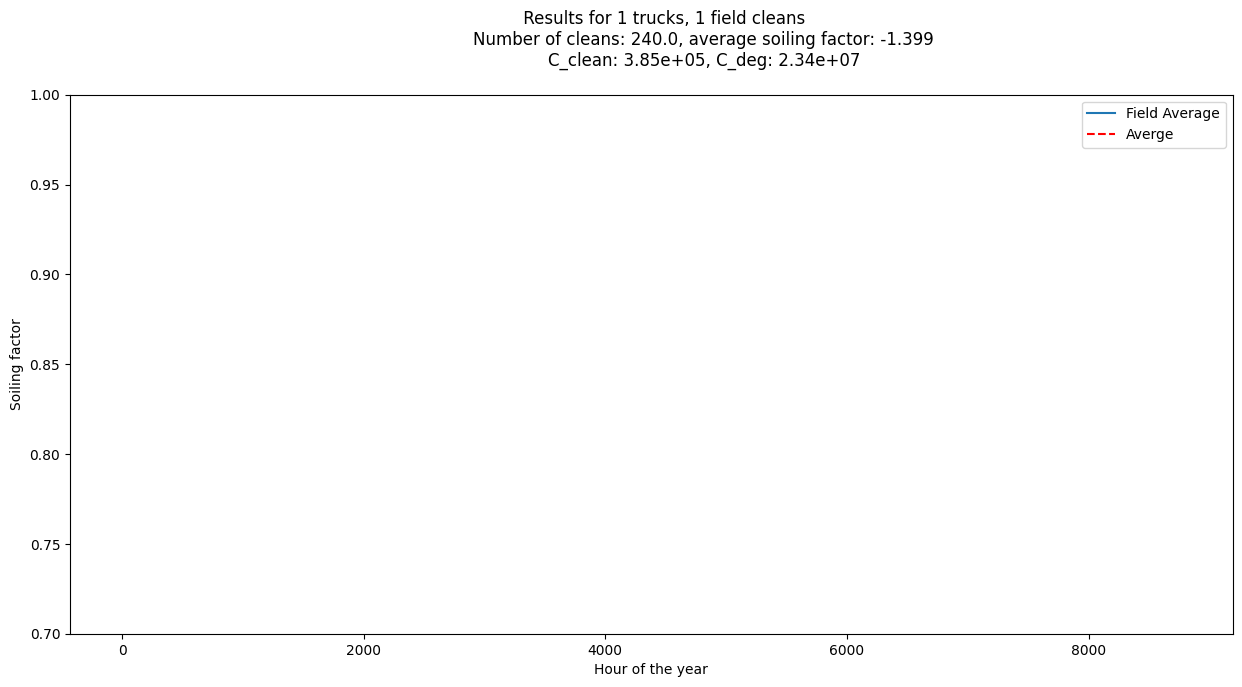

In [55]:
results_opt = co.periodic_schedule_tcc(opt,r+1,c+1,\
    n_sectors_per_truck=n_sectors_cleaned_per_truck,verbose=False)
nh,nt = results_opt['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results_opt['soiling_factor'][0]
ax.plot(sf.mean(axis=0),label="Field Average")

# add average
ax.axhline(y=np.nanmean(sf),color='red',ls='--',label="Averge")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Soiling factor")
ax.legend()
cleans = results_opt['cleaning_actions'][0] # same for all runs
ax.set_title(title_str.format(r+1,c+1,cleans.sum(),np.nanmean(sf),
                              results_opt['direct_cleaning_costs'].sum(),
                              results_opt['degradation_costs'].sum()))
ax.set_ylim((0.7,1.0))


# ax.set_title()


Field-averaged efficiency

C:\Users\Cody Anderson\AppData\Local\Temp\ipykernel_18928\3565455723.py:6: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(eta_soiled,axis=0),label="Field Average (above stow angle only)")


KeyError: 'soiling_induced_off_times'

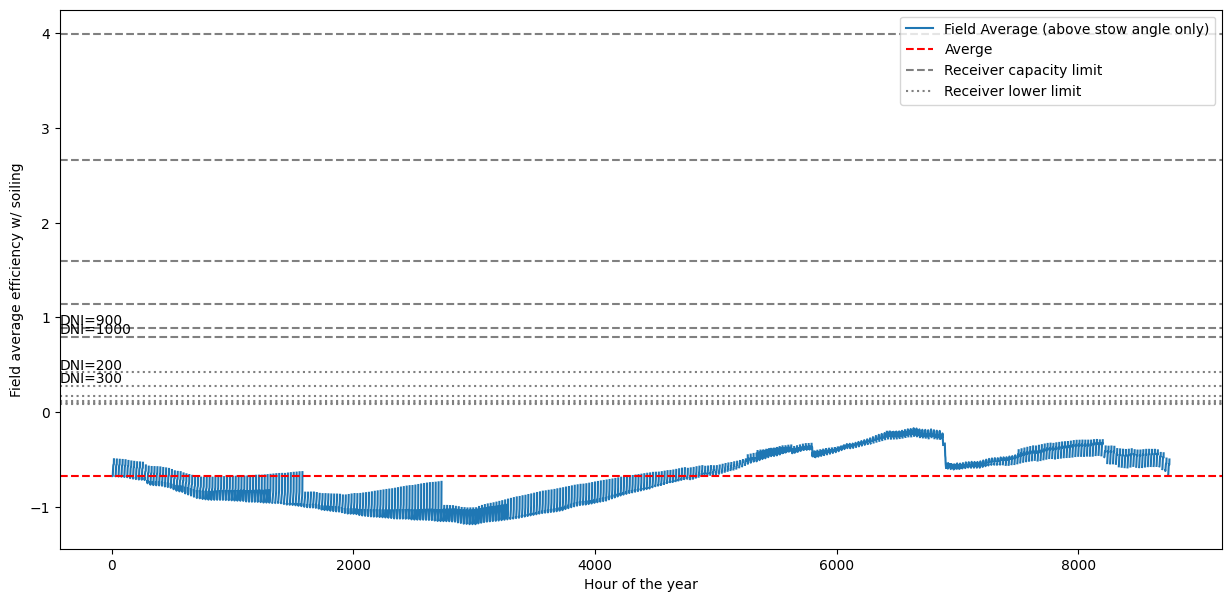

In [56]:
nh,nt = results_opt['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results_opt['soiling_factor'][0]
eta_clean = opt.field_model.helios.optical_efficiency[f]*opt.field_model.helios.nominal_reflectance
eta_soiled = sf*eta_clean
ax.plot(np.nanmean(eta_soiled,axis=0),label="Field Average (above stow angle only)")
# ax.plot(nt-1,eta_soiled[:,0].mean(),'*')
# ax.plot(0,eta_soiled[:,-1].mean(),'*')
ax.axhline(y=np.nanmean(eta_soiled),color='red',ls='--',label="Averge")   
add_limits(ax,u_limits,l_limits,DNI_MW)

ax.set_xlabel("Hour of the year")
ax.set_ylabel("Field average efficiency w/ soiling")
ax.legend()

cleans = results_opt['cleaning_actions'][0] # same for all runs
ax.set_title(title_str.format(r+1,c+1,cleans.sum(),np.nanmean(sf),
                              results_opt['direct_cleaning_costs'].sum(),
                              results_opt['degradation_costs'].sum()))

ax.set_ylim((0,1))

Schedule for optimum

In [ ]:
N_sectors = n_az*n_rad
ax = plt.subplot()
ax.spy(cleans,aspect='auto',marker='.',label="cleans")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Sector")
ax.legend()

Results for a chosen sub-optimal combination

In [ ]:
ntr,nc = 2,15
results_so = co.periodic_schedule_tcc(opt,ntr,nc,\
    n_sectors_per_truck=n_sectors_cleaned_per_truck,verbose=False)
nh,nt = results_so['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results_so['soiling_factor'][0]
ax.plot(sf.mean(axis=0),label="Field Average")
ax.plot(nt-1,sf[:,0].mean(),'*')
ax.plot(0,sf[:,-1].mean(),'*')
ax.axhline(y=np.nanmean(sf),color='red',ls='--',label="Averge")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Soiling factor")
ax.legend()

cleans = results_so['cleaning_actions'][0] # same for all runs
ax.set_title(title_str.format(ntr,nc,cleans.sum(),np.nanmean(sf),
                              results_so['direct_cleaning_costs'].sum(),
                              results_so['degradation_costs'].sum(),
                              results_so['soiling_induced_off_times'],
                              results_so['soiling_induced_drops_below_upper_limit']))
ax.set_ylim((0.7,1.0))


Field optical efficiency analysis

In [ ]:
nh,nt = results_so['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results_so['soiling_factor'][0]
eta_clean = opt.field_model.helios.optical_efficiency[f]*opt.field_model.helios.nominal_reflectance
eta_soiled = sf*eta_clean
ax.plot(np.nanmean(eta_soiled,axis=0),label="Field Average (above stow angle only)")
# ax.plot(nt-1,eta_soiled[:,0].mean(),'*')
# ax.plot(0,eta_soiled[:,-1].mean(),'*')
ax.axhline(y=np.nanmean(eta_soiled),color='red',ls='--',label="Averge")   
add_limits(ax,u_limits,l_limits,DNI_MW)

ax.set_xlabel("Hour of the year")
ax.set_ylabel("Field average efficiency w/ soiling")
ax.legend()

cleans = results_so['cleaning_actions'][0] # same for all runs
ax.set_title(title_str.format(ntr,nc,cleans.sum(),np.nanmean(sf),
                              results_so['direct_cleaning_costs'].sum(),
                              results_so['degradation_costs'].sum(),
                              results_so['soiling_induced_off_times'],
                              results_so['soiling_induced_drops_below_upper_limit']))

ax.set_ylim((0,1))